In [2]:
# imports

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from scipy import integrate
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
""""

Need:

- import of the spectra 
- convert data to a good spectrum - the units etc 
- plot the spectrum
- mask emission lines in region for cont fit 
- use emcee to fit b uv 
- extropolate the fit to the region of the emission line and get f cont
- plot the fit
- use to find lya damping parameter
- plot 
- extend to multiple spectra 



"""

'"\n\nNeed:\n\n- import of the spectra \n- convert data to a good spectrum - the units etc \n- plot the spectrum\n- mask emission lines in region for cont fit \n- use emcee to fit b uv \n- extropolate the fit to the region of the emission line and get f cont\n- plot the fit\n- use to find lya damping parameter\n- plot \n- extend to multiple spectra \n\n\n\n'

In [65]:
# Import the data

filepath = '/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_265801.spec.fits'

tab = Table.read(filepath, format='fits')

tab

# Redshift
z = 9.4385

In [66]:
tab

wave,flux,err,sky,path_corr,npix,norm_corr,flux_sum,profile_sum,var_sum
um,uJy,uJy,uJy,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.58,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5836851085753291,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5874378771811705,--,--,--,--,0.0,--,0.0,0.0,0.0
0.591260215571612,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5951542612478814,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5991219350103587,--,--,--,--,0.0,--,0.0,0.0,0.0
0.6031652486825945,-0.007672857145876609,0.0031370790059322543,0.005350439823142702,1.2330348996784237,172.0,1.0152484521430793,-0.5917071796281094,31.77121477272592,0.023610437845469137
0.6072866429848921,0.0026173763492408613,0.0023985686687850905,0.003948030917045336,1.2513570905562055,275.0,1.0173457332817553,0.34949958777623097,52.17460643217744,0.038109178916915426


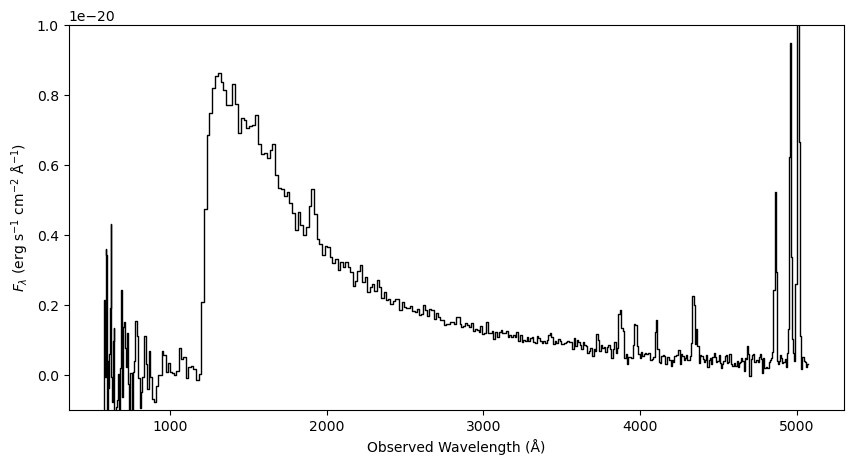

In [67]:
# convert data

# Constants
c = 3e18  # Speed of light in Å/s
conversion_factor = 3e-11  # Factor from the conversion formula

# Convert wavelength from microns (µm) to angstroms (Å)
wavelengths_microns = tab['wave']  # Wavelengths in µm
wavelengths_angstroms = wavelengths_microns * 1e4  # Convert to Å

# Flux in µJy
flux_microjy = tab['flux']  # Flux in µJy
flux_err_microjy = tab['err']  # Error in flux in µJy

# Conversion from µJy to erg/s/cm²/Å for each wavelength
flux_erg_per_s_cm2_A = (flux_microjy * conversion_factor) / (wavelengths_angstroms**2)
flux_err_erg_per_s_cm2_A = (flux_err_microjy * conversion_factor) / (wavelengths_angstroms**2)

tab['wave_angstroms'] = wavelengths_angstroms
tab['flux_erg_per_s_cm2_A'] = flux_erg_per_s_cm2_A
tab['flux_err_erg_per_s_cm2_A'] = flux_err_erg_per_s_cm2_A


# Convert observed wavelength to rest-frame wavelength
rest_wave_microns = wavelengths_microns / (1 + z)
rest_wave_angstroms = wavelengths_angstroms / (1 + z)



# Plotting the data using the rest-frame wavelength
plt.figure(figsize=(10, 5))
plt.plot(rest_wave_angstroms, tab['flux_erg_per_s_cm2_A'], color='black', lw=1, drawstyle='steps-mid')
plt.xlabel('Observed Wavelength (Å)')  
# f subscript lambda label
plt.ylabel(r'$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
#plt.xlim(800, 5500)  
plt.ylim(-0.1e-20, 1.0e-20) 
plt.show()



Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 74
    # variables        = 2
    chi-square         = 0.07350647
    reduced chi-square = 0.00102092
    Akaike info crit   = -507.669076
    Bayesian info crit = -503.060946
    R-squared          = 0.97521034
[[Variables]]
    beta:         -2.56102048 +/- 0.04812081 (1.88%) (init = -2)
    log_FUV_1550: -20.1661262 +/- 0.00650958 (0.03%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8212


100%|██████████| 1000/1000 [00:17<00:00, 58.04it/s]


β_UV: -2.58 with 16-84 percentile range: [-2.58, -2.58]


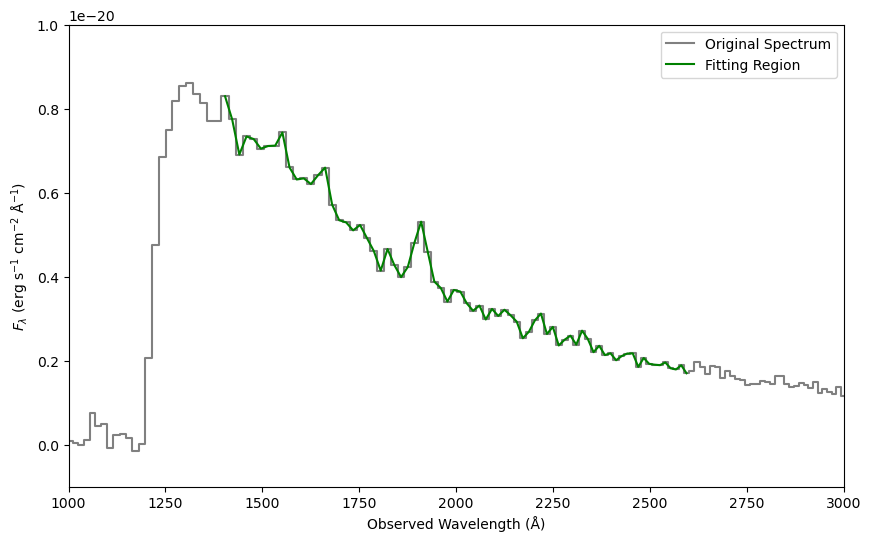

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
import emcee

# Assuming rest_wave_angstroms and tab['flux_erg_per_s_cm2_A'] are defined
wavelength = rest_wave_angstroms
flux = tab['flux_erg_per_s_cm2_A']
flux_err = tab['flux_err_erg_per_s_cm2_A']

# Mask to region we want to fit (between 1400 Å and 2600 Å)
mask = ((wavelength >= 1400) & (wavelength <= 2600))
wavelength_masked = wavelength[mask]
flux_masked = flux[mask]
flux_err_masked = flux_err[mask]  

# Log transformation of data for linear fit
log_wavelength = np.log10(wavelength_masked)
log_flux = np.log10(flux_masked)

# Define model: log_flux = beta * log_wavelength + log_FUV_1550
def uv_slope_model(log_wavelength, beta, log_FUV_1550):
    return beta * (log_wavelength - np.log10(1550)) + log_FUV_1550

# Initialize lmfit model
model = Model(uv_slope_model)
params = Parameters()
params.add('beta', value=-2.0)  # Initial guess for beta
params.add('log_FUV_1550', value=np.log10(1e-15))  # Initial guess for FUV_1550 in log scale

# Perform fit to get initial parameters
result = model.fit(log_flux, params, log_wavelength=log_wavelength)
print("Initial Fit Results:")
print(result.fit_report())

# MCMC sampling with emcee
# Define objective function for MCMC
def log_probability(param_array, log_wavelength, log_flux, flux_err):
    beta, log_FUV_1550 = param_array
    model_flux = uv_slope_model(log_wavelength, beta, log_FUV_1550)
    sigma2 = flux_err**2 + model_flux**2 * np.exp(2 * log_FUV_1550)  
    return -0.5 * np.sum((log_flux - model_flux)**2 / sigma2 + np.log(sigma2))

# Set up emcee sampler
nwalkers = 50
ndim = 2
initial_positions = [result.params['beta'].value, result.params['log_FUV_1550'].value]
p0 = [initial_positions + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(log_wavelength, log_flux, flux_err_masked))
sampler.run_mcmc(p0, 1000, progress=True)

# Extract results
samples = sampler.get_chain(discard=100, thin=10, flat=True)
beta_samples, log_FUV_1550_samples = samples[:, 0], samples[:, 1]

# Calculate median and credible intervals
beta_median = np.median(beta_samples)
beta_ci = np.percentile(beta_samples, [16, 84])

print(f"β_UV: {beta_median:.2f} with 16-84 percentile range: [{beta_ci[0]:.2f}, {beta_ci[1]:.2f}]")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label="Original Spectrum", color="gray", drawstyle='steps-mid')
plt.plot(wavelength_masked, flux_masked, 'green', label="Fitting Region")
plt.xlabel("Observed Wavelength (Å)")
plt.ylabel(r'$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
#plt.ylim(-0.1e-20, 1.0e-20)
plt.xlim(1000,3000)
plt.ylim(-0.1e-20, 1.0e-20)
plt.legend()
plt.show()


Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 74
    # variables        = 2
    chi-square         = 0.07350647
    reduced chi-square = 0.00102092
    Akaike info crit   = -507.669076
    Bayesian info crit = -503.060946
    R-squared          = 0.97521034
[[Variables]]
    beta:         -2.56102048 +/- 0.04812081 (1.88%) (init = -2)
    log_FUV_1550: -20.1661262 +/- 0.00650958 (0.03%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8212


100%|██████████| 1000/1000 [00:16<00:00, 60.22it/s]

β_UV: -2.58 with 16-84 percentile range: [-2.58, -2.58]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


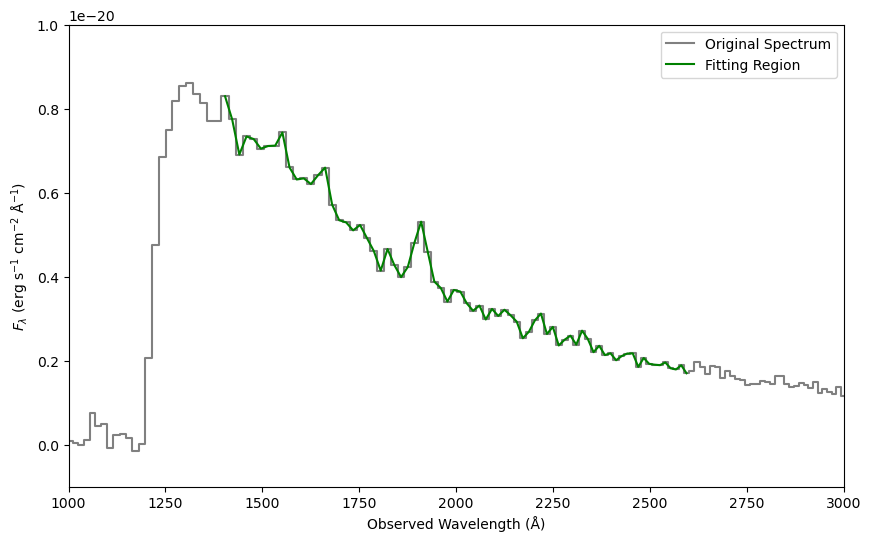

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model, Parameters
import emcee

def mask_wavelength_region(wavelength, flux, flux_err, min_wavelength=1400, max_wavelength=2600):
    """
    Apply a mask to select the wavelength region between min_wavelength and max_wavelength.
    """
    mask = (wavelength >= min_wavelength) & (wavelength <= max_wavelength)
    return wavelength[mask], flux[mask], flux_err[mask]

def log_transform(wavelength, flux):
    """
    Log transform the wavelength and flux data for linear fitting.
    """
    return np.log10(wavelength), np.log10(flux)

def uv_slope_model(log_wavelength, beta, log_FUV_1550):
    """
    UV slope model: log_flux = beta * (log_wavelength - log(1550)) + log_FUV_1550.
    """
    return beta * (log_wavelength - np.log10(1550)) + log_FUV_1550

def initial_fit(log_wavelength, log_flux):
    """
    Perform an initial fit using lmfit to get the UV slope and log FUV 1550 parameters.
    """
    model = Model(uv_slope_model)
    params = Parameters()
    params.add('beta', value=-2.0)  # Initial guess for beta
    params.add('log_FUV_1550', value=np.log10(1e-15))  # Initial guess for log_FUV_1550

    result = model.fit(log_flux, params, log_wavelength=log_wavelength)
    print("Initial Fit Results:")
    print(result.fit_report())
    return result

def log_probability(param_array, log_wavelength, log_flux, flux_err):
    """
    Objective function for MCMC that calculates the log-probability.
    """
    beta, log_FUV_1550 = param_array
    model_flux = uv_slope_model(log_wavelength, beta, log_FUV_1550)
    sigma2 = flux_err**2 + model_flux**2 * np.exp(2 * log_FUV_1550)
    return -0.5 * np.sum((log_flux - model_flux)**2 / sigma2 + np.log(sigma2))

def run_mcmc(log_wavelength, log_flux, flux_err, result, nwalkers=50, steps=1000):
    """
    Perform MCMC sampling using emcee with the initial fit results as starting points.
    """
    ndim = 2
    initial_positions = [result.params['beta'].value, result.params['log_FUV_1550'].value]
    p0 = [initial_positions + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(log_wavelength, log_flux, flux_err))
    sampler.run_mcmc(p0, steps, progress=True)
    samples = sampler.get_chain(discard=100, thin=10, flat=True)
    return samples

def get_mcmc_results(samples):
    """
    Calculate the median and credible intervals for beta from MCMC samples.
    """
    beta_samples, log_FUV_1550_samples = samples[:, 0], samples[:, 1]
    beta_median = np.median(beta_samples)
    beta_ci = np.percentile(beta_samples, [16, 84])
    log_FUV_1550_median = np.median(log_FUV_1550_samples)
    log_FUV_1550_ci = np.percentile(log_FUV_1550_samples, [16, 84])

    print(f"β_UV: {beta_median:.2f} with 16-84 percentile range: [{beta_ci[0]:.2f}, {beta_ci[1]:.2f}]")
    print(f"log_FUV_1550: {log_FUV_1550_median:.2e} with 16-84 percentile range: [{log_FUV_1550_ci[0]:.2e}, {log_FUV_1550_ci[1]:.2e}]")
    
    return beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci


def plot_spectrum(wavelength, flux, wavelength_masked, flux_masked):
    """
    Plot the original spectrum and the masked region for fitting.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label="Original Spectrum", color="gray", drawstyle='steps-mid')
    plt.plot(wavelength_masked, flux_masked, 'green', label="Fitting Region")
    plt.xlabel("Observed Wavelength (Å)")
    plt.ylabel(r'$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
    plt.xlim(1000, 3000)
    plt.ylim(-0.1e-20, 1.0e-20)
    plt.legend()
    plt.show()

# Main analysis pipeline
def analyze_uv_spectrum(wavelength, flux, flux_err):
    # Mask to fitting region
    wavelength_masked, flux_masked, flux_err_masked = mask_wavelength_region(wavelength, flux, flux_err)
    
    # Log transformation
    log_wavelength, log_flux = log_transform(wavelength_masked, flux_masked)
    
    # Initial fit
    result = initial_fit(log_wavelength, log_flux)
    
    # MCMC sampling
    samples = run_mcmc(log_wavelength, log_flux, flux_err_masked, result)
    
    # MCMC results
    beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci  = get_mcmc_results(samples)
    
    # Plotting
    plot_spectrum(wavelength, flux, wavelength_masked, flux_masked)

    return beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci

# Example usage with assumed data

beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci = analyze_uv_spectrum(rest_wave_angstroms, tab['flux_erg_per_s_cm2_A'], tab['flux_err_erg_per_s_cm2_A'])


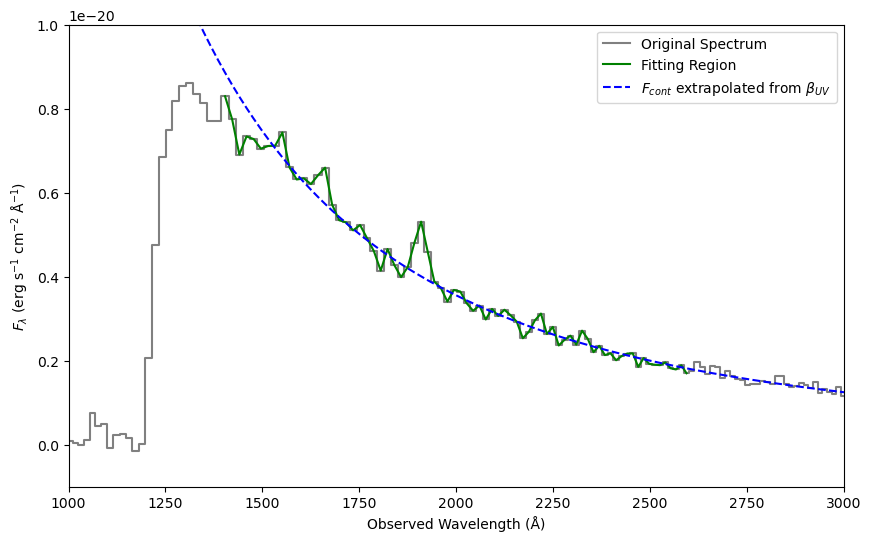

In [81]:
def extrapolate_continuum(wavelength, beta_median, log_FUV_1550_median):
    """
    Extrapolate the full continuum across the wavelength range using the MCMC-derived slope (beta)
    and normalization (log_FUV_1550).
    
    Parameters:
    - wavelength: Array of wavelength values (in Å).
    - beta_median: Median value of beta from MCMC results.
    - log_FUV_1550_median: Median value of log_FUV_1550 from MCMC results.

    Returns:
    - f_cont: The extrapolated continuum flux values across the wavelength range.
    """
    log_wavelength = np.log10(wavelength)
    log_f_cont = beta_median * (log_wavelength - np.log10(1550)) + log_FUV_1550_median
    f_cont = 10**log_f_cont  # Convert back from log scale to linear scale
    return f_cont

def plot_spectrum_with_continuum(wavelength, flux, wavelength_masked, flux_masked, f_cont):
    """
    Plot the original spectrum, masked region, and the extrapolated continuum.

    Parameters:
    - wavelength: Array of full wavelength values (in Å).
    - flux: Array of full flux values.
    - wavelength_masked: Masked wavelength array used for fitting.
    - flux_masked: Masked flux array used for fitting.
    - f_cont: Extrapolated continuum flux values across the full wavelength range.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label="Original Spectrum", color="gray", drawstyle='steps-mid')
    plt.plot(wavelength_masked, flux_masked, 'green', label="Fitting Region")
    plt.plot(wavelength, f_cont, color="blue", linestyle="--", label=r'$F_{cont}$ extrapolated from $\beta_{UV}$')
    plt.xlabel("Observed Wavelength (Å)")
    plt.ylabel(r'$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
    plt.xlim(1000, 3000)
    plt.ylim(-0.1e-20, 1.0e-20)
    plt.legend()
    plt.show()

# To use in the main pipeline:
# After calling get_mcmc_results:
f_cont = extrapolate_continuum(wavelength, beta_median, log_FUV_1550_median)
plot_spectrum_with_continuum(wavelength, flux, wavelength_masked, flux_masked, f_cont)


In [98]:
from scipy.integrate import simps

def calculate_damping_parameter(wavelength, flux, f_cont, zspec, lambda_LyA_low=1180, lambda_LyA_up=1350):
    """
    Calculate the LyA damping parameter (D_LyA) over the specified wavelength range.

    Parameters:
    - wavelength: Array of observed wavelengths (in Å).
    - flux: Array of observed flux values.
    - f_cont: Array of extrapolated continuum flux values.
    - zspec: Redshift of the source.
    - lambda_LyA_low: Lower limit of the LyA region in the rest-frame (default: 1180 Å).
    - lambda_LyA_up: Upper limit of the LyA region in the rest-frame (default: 1350 Å).

    Returns:
    - DLyA: The calculated LyA damping parameter.
    """
   
    
    # Mask to Lyα region in the observed frame
    mask = (wavelength >= lambda_LyA_low) & (wavelength <= lambda_LyA_up )
    wavelength_LyA = wavelength[mask]
    flux_LyA = flux[mask]
    f_cont_LyA = f_cont[mask]
    
    # Calculate the (1 - Fλ / Fcont) term over the masked region
    integrand = (1 - flux_LyA / f_cont_LyA)
    
    # Integrate over the wavelength range using Simpson's rule
    DLyA = simps(integrand, wavelength_LyA) / (1 + zspec)
    
    return DLyA

DLyA = calculate_damping_parameter(rest_wave_angstroms, tab['flux_erg_per_s_cm2_A'], f_cont, z)
print(f"LyA Damping Parameter (D_LyA): {DLyA:.3f}")


LyA Damping Parameter (D_LyA): 6.159


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_35931/286108553.py:30: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  DLyA = simps(integrand, wavelength_LyA) / (1 + zspec)


In [89]:
def is_lyman_alpha_in_range(wavelength, zspec, lambda_LyA_low=1180, lambda_LyA_up=1350):
    """
    Checks if the redshifted Lyα line range is within the observed wavelength range.

    Parameters:
    - wavelength: Array of observed wavelengths (in Å).
    - zspec: Redshift of the source.
    - lambda_LyA_low: Lower limit of the Lyα region in the rest-frame (default: 1180 Å).
    - lambda_LyA_up: Upper limit of the Lyα region in the rest-frame (default: 1350 Å).

    Returns:
    - in_range: Boolean indicating if the Lyα range is within the observed wavelength range.
    """
    # Convert rest-frame limits to observed frame
    lambda_low_obs = lambda_LyA_low * (1 + zspec)
    lambda_up_obs = lambda_LyA_up * (1 + zspec)

    print(f"Lyα range in observed frame: {lambda_low_obs:.2f} - {lambda_up_obs:.2f} Å")
    
    
    # Check if the observed Lyα range is within the wavelength bounds
    in_range = wavelength.min() <= lambda_low_obs <= wavelength.max() or \
               wavelength.min() <= lambda_up_obs <= wavelength.max()
    
    return in_range

# Example usage with actual redshift
zspec = 9.4385
lyman_alpha_in_range = is_lyman_alpha_in_range(rest_wave_angstroms, zspec)
print(f"Is the Lyα range in wavelength data range? {lyman_alpha_in_range}")


Lyα range in observed frame: 12317.43 - 14091.97 Å
Is the Lyα range in wavelength data range? False


In [ ]:
import numpy as np
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from lmfit import Model, Parameters

# Function to fit the UV slope (beta_UV) from 1400-2600Å rest-frame
def fit_uv_slope(log_wavelength, log_flux):
    # Fit a linear model to the log-transformed data
    def uv_slope_model(log_wavelength, beta, log_FUV_1550):
        return beta * (log_wavelength - np.log10(1550)) + log_FUV_1550

    model = Model(uv_slope_model)
    params = Parameters()
    params.add('beta', value=-1.0)  # Initial guess for beta
    params.add('log_FUV_1550', value=np.log10(1e-19))  # Initial guess for FUV_1550 in log scale

    # Perform fit to get initial parameters
    result = model.fit(log_flux, params, log_wavelength=log_wavelength)
    return result.params['log_FUV_1550'].value, result.params['beta'].value

# Function to compute the continuum flux (F_cont) using the UV slope
def extrapolate_continuum(wavelength, z_spec, log_FUV_1550, beta):
    rest_wavelength = wavelength / (1 + z_spec)
    A = 10**log_FUV_1550  # Convert back to original scale
    return A * rest_wavelength ** beta

# Function to compute the Lyα damping parameter
def ly_alpha_damping_parameter(wavelength, flux, flux_err, z_spec):
    # Apply Gaussian smoothing to the flux for noise reduction
    flux_smoothed = gaussian_filter1d(flux, sigma=3)  # Adjust sigma for smoothing
    
    # Convert to log scale for fitting
    log_wavelength = np.log10(wavelength / (1 + z_spec))
    log_flux = np.log10(flux_smoothed)

    # Fit the UV slope to estimate the continuum flux
    log_FUV_1550, beta = fit_uv_slope(log_wavelength, log_flux)

    # Extrapolate the continuum flux over the entire wavelength range
    F_cont = extrapolate_continuum(wavelength, z_spec, log_FUV_1550, beta)

    # Define the Lyman-alpha wavelength in rest-frame (1215.67 Å)
    ly_alpha_rest = 1215.67
    
    # Convert the observed wavelength to rest-frame
    rest_wavelength = wavelength / (1 + z_spec)
    
    # Select the region around Lyman-alpha (e.g., +/- 50Å around 1215.67 Å)
    mask = (rest_wavelength >= ly_alpha_rest - 50) & (rest_wavelength <= ly_alpha_rest + 50)
    wavelength_lya = wavelength[mask]
    flux_lya = flux_smoothed[mask]
    F_cont_lya = F_cont[mask]
    
    # Calculate the damping parameter
    damping_term = 1 - (flux_lya / F_cont_lya)
    
    # Perform the integration using the trapezoidal rule
    damping_param = simps(damping_term, wavelength_lya) / (1 + z_spec)
    
    return damping_param

# Example usage:
# Load the spectrum (wavelength and flux should be numpy arrays with your data)
from astropy.table import Table
filepath = '/Users/s2537809/Downloads/jades-gds-wide2-v3_prism-clear_1180_105840.spec.fits'
tab = Table.read(filepath, format='fits')

# Extract the wavelength and flux
wavelength = np.array(tab['wave']) * 10**4  # Convert from microns to angstroms
flux = np.array(tab['flux'])
flux_err = np.array(tab['flux_err'])  # Include flux errors if available

# Set the redshift of the galaxy
z_spec = 6.09  # Replace with the actual redshift

# Calculate the Lyman-alpha damping parameter
damping_parameter = ly_alpha_damping_parameter(wavelength, flux, flux_err, z_spec)
print(f"Lyman-alpha Damping Parameter: {damping_parameter}")

# Plot the smoothed and original flux for comparison
plt.figure(figsize=(12, 4))
plt.plot(wavelength, flux, label='Original Flux', alpha=0.5, drawstyle='steps-mid')
plt.plot(wavelength, gaussian_filter1d(flux, sigma=3), label='Smoothed Flux', alpha=0.8)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.legend()
plt.title('Original vs Smoothed Spectrum')
plt.show()
